In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score


In [2]:
print("Load the data.")
df_x_train = pd.read_csv('X_train.csv',header = 0 ,index_col=0)
df_y_train = pd.read_csv('y_train.csv',header = 0 ,index_col=0)
df_x_test = pd.read_csv('X_test.csv',header = 0 ,index_col=0)
x_train = df_x_train.values
y_train = df_y_train['y'].values
x_test = df_x_test.values

Load the data.


In [3]:
print('Check training data.')
print(df_x_train.head())
print(df_x_train.shape)
print('There are %d NAN values.'%np.sum(np.isnan(x_train)))
print(df_y_train.groupby('y').size())

Check training data.
           x0        x1        x2        x3        x4        x5        x6  \
id                                                                          
0.0 -1.099144  0.918165 -1.227394  0.887061  1.182734 -0.371802 -0.127331   
1.0  0.366477  0.933802  0.061234  0.430073  1.029673 -0.613771  0.364698   
2.0 -0.425879 -0.802152  0.002718  0.820036  1.490237 -0.888121  0.769524   
3.0  0.822922 -0.843041 -0.734624 -0.000040  0.123783 -1.777226  0.364601   
4.0 -0.285342 -0.641116  0.436524 -0.618663  0.319982 -1.160489  0.528379   

           x7        x8        x9  ...      x990      x991      x992  \
id                                 ...                                 
0.0  1.201702  1.825839  2.944655  ... -1.111422  1.566261 -1.656656   
1.0  1.140867  0.182811 -0.344876  ... -0.672386 -0.003721 -0.496326   
2.0  1.059020  0.854806 -0.077359  ... -1.031358 -0.085724 -0.557461   
3.0  0.425521  1.265122  0.734897  ... -0.118974  1.271367 -1.518161   
4.0  0.

In [4]:
standardization = True
feature_selection = True
fs_down_s = True
fs_over_s = False
outlier_detection = False

In [5]:
# standardization
if standardization:
    print('Standardize the data.')
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train =scaler.transform(x_train)
    x_test=scaler.transform(x_test)

Standardize the data.


Plot the first two principle components:


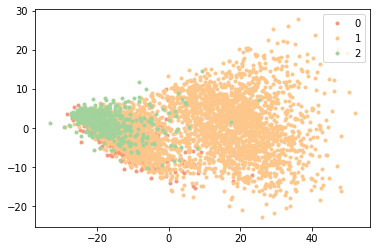

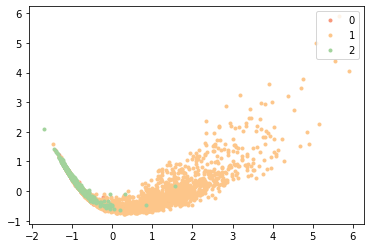

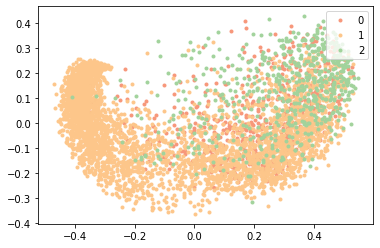

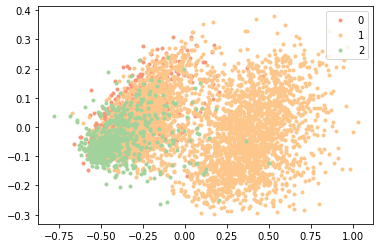

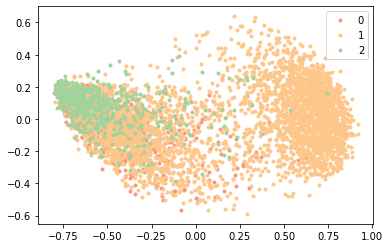

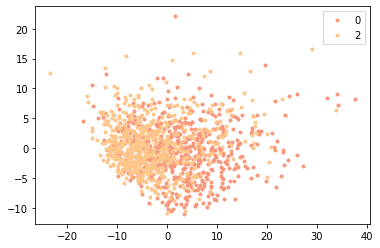

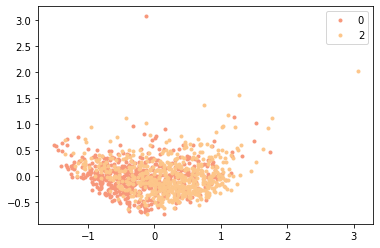

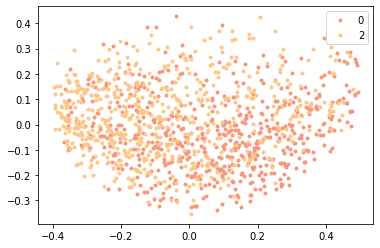

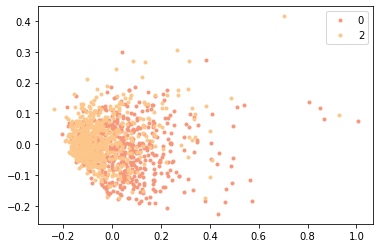

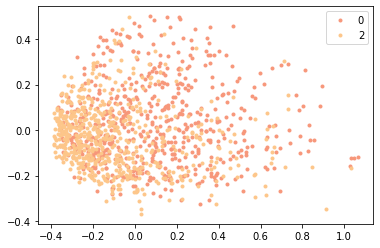

In [7]:
#play with data
print("Plot the first two principle components:")

kernel = [ "linear", "poly", "rbf", "sigmoid", "cosine"]
colors = ['#F7977A','#FDC68A','#A2D39C','#6ECFF6','#8493CA','#BC8DBF','#F6989D','#FFF79A']

def plot_2D_pca(transformed_x,y):
    labels = np.unique(y)
    legend = []
    plt.figure()
    for i,label in enumerate(labels):
        idx = np.where(y==label)[0]
        plot = plt.plot(transformed_x[idx,0],transformed_x[idx,1],'.',color=colors[i])
        legend.append(plt)
        plt.legend(labels,loc="upper right")
    # axes = plt.gca()
    # axes.set_xlim([-10,10])
    # axes.set_ylim([-10,10])
def plot_by_class(x_train,y_train,class_list=None):
    if class_list != None:
        ind = [(i in class_list) for i in y_train]
        x_train = x_train[ind,:]
        y_train = y_train[ind]
    for k in kernel:
        pca = KernelPCA(n_components=5, kernel=k)
        pca_x_train = pca.fit_transform(x_train)
        plot_2D_pca(pca_x_train,y_train)

plot_by_class(x_train,y_train,[0,1,2])
plot_by_class(x_train,y_train,[0,2])

In [6]:
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler


model_smote = SMOTE()
x_over_train, y_over_train = model_smote.fit_sample(x_train,y_train)

model_RandomUnderSampler = RandomUnderSampler() 
x_down_train, y_down_train =model_RandomUnderSampler.fit_sample(x_train,y_train)


In [9]:
#feature selection
from sklearn.feature_selection import SelectFromModel, SelectKBest,f_classif,mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

def feature_selection(x_train, y_train, x_test, method="rf", max_features=200):
    if(method == 'rf'):
        sel = SelectFromModel(RandomForestClassifier(n_estimators=100,class_weight='balanced'), threshold=-np.inf, max_features=max_features)
        sel.fit(x_train, y_train)
        indicator = sel.get_support()
        index = np.where(indicator==False)[0]

        print("select %d features!" % (indicator.shape[0] - index.shape[0]))
        x_train_fs = np.delete(x_train, index, axis=1)
        x_test_fs = np.delete(x_test, index, axis=1)
        return x_train_fs, x_test_fs
    
    elif(method == 'xgb'):
        sel = SelectFromModel(XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0.01, subsample=0.8, colsample_bytree=1, min_child_weight=5, max_depth=3), threshold=-np.inf, max_features=max_features)
        sel.fit(x_train, y_train)
        indicator = sel.get_support()
        index = np.where(indicator==False)[0]

        print("select %d features!" % (indicator.shape[0] - index.shape[0]))
        x_train_fs = np.delete(x_train, index, axis=1)
        x_test_fs = np.delete(x_test, index, axis=1)
        return x_train_fs, x_test_fs

    elif(method == 'freg'):
        #x_train = SelectKBest(f_regression, k=200).fit_transform(x_train, y_train)
        sel = SelectKBest(f_classif, k=max_features)
        sel.fit(x_train, y_train)
        indicator = sel.get_support()
        index = np.where(indicator==False)[0]

        print("select %d features!" % (indicator.shape[0] - index.shape[0]))
        x_train_fs = np.delete(x_train, index, axis=1)
        x_test_fs = np.delete(x_test, index, axis=1)
        return x_train_fs, x_test_fs
    
    elif(method == 'mir'):
        sel = SelectKBest(mutual_info_classif, k=max_features)
        sel.fit(x_train, y_train)
        indicator = sel.get_support()
        index = np.where(indicator==False)[0]

        print("select %d features!" % (indicator.shape[0] - index.shape[0]))
        x_train_fs = np.delete(x_train, index, axis=1)
        x_test_fs = np.delete(x_test, index, axis=1)
        return x_train_fs, x_test_fs
    

fs_x_down_train,fs_x_down_test = feature_selection(x_down_train,y_down_train,x_test,"rf",500)
fs_x_over_train,fs_x_over_test = feature_selection(x_over_train,y_over_train,x_test,"rf",500)
fs_x_train,fs_x_test = feature_selection(x_train,y_train,x_test,"rf",500) 


select 500 features!
select 500 features!
select 500 features!


In [ ]:
# remove outliers
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
def outlier_detection(x_train, y_train, method='isoforest'):
    if(method == 'isoforest'):
        rng = np.random.RandomState(42)
        clf = IsolationForest(behaviour='new', max_samples=100,
                          random_state=rng, contamination='auto')
        clf.fit(x_train)
        indicator = clf.predict(x_train)
        index = np.where(indicator == -1)[0]
        print("detect %d outliers in training set!" % (index.shape[0]))

        x_train_clean = np.delete(x_train, index, axis=0)
        y_train_clean = np.delete(y_train, index, axis=0)

        return x_train_clean, y_train_clean
    
    elif(method == 'lof'):
        clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
        clf.fit(x_train)
        indicator = clf.fit_predict(x_train)
        index = np.where(indicator == -1)[0]
        print("detect %d outliers in training set!" % (index.shape[0]))

        x_train_clean = np.delete(x_train, index, axis=0)
        y_train_clean = np.delete(y_train, index, axis=0)
        return x_train_clean,y_train_clean
    
if outlier_detection:
    x_train,y_train = outlier_detection(x_train,y_train,method='lof')


In [7]:
def custom_accuracy(preds, train_data):
    labels = train_data.get_label()
    n = len(labels)
    results = []
    for i in range(n):
        results.append(np.argmax([preds[i], preds[n + i], preds[2*n + i]]))
    return 'BMAC', balanced_accuracy_score(labels, results), True

import lightgbm as lgb

def lgb_cv(x_train,y_train,params):
    lgb_train = lgb.Dataset(x_train, y_train)
    cv_results = lgb.cv(
            params,
            lgb_train,
            num_boost_round=100,
            nfold=5,
            feval=custom_accuracy,
            early_stopping_rounds=20
            )
    print('------------------')  ###
    print('Best num_boost_round:',len(cv_results['multi_logloss-mean']))
    print('Best CV score:',cv_results['BMAC-mean'][-1])

In [10]:
# over-sampling has a higher score just because there're repeated samples in train & val
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclassova',
    'is_unbalance': True,
    #'metric': 'None',
    'num_class': 3,
    'num_leaves': 9,
    'learning_rate': 0.05,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'verbose': 0,
}
lgb_cv(fs_x_down_train,y_down_train,params)
lgb_cv(fs_x_over_train,y_over_train,params)
lgb_cv(fs_x_train,y_train,params)

lgb_cv(x_down_train,y_down_train,params)
lgb_cv(x_over_train,y_over_train,params)
lgb_cv(x_train,y_train,params)

----results using 
Best num_boost_round: 66
Best CV score: 0.6744444444444445
----results using 
Best num_boost_round: 100
Best CV score: 0.8207407407407408
----results using 
Best num_boost_round: 84
Best CV score: 0.667962962962963
----results using 
Best num_boost_round: 63
Best CV score: 0.6683333333333334
----results using 
Best num_boost_round: 100
Best CV score: 0.8287037037037038
----results using 
Best num_boost_round: 98
Best CV score: 0.6647222222222222


In [11]:
# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclassova',
    'is_unbalance': True,
    #'metric': {'l1', 'l2'},
    'num_class': 3,
    'num_leaves': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'verbose': 0,
}
def train_lightgbm(x_train,y_train,params,n_iter=10,choose_best=True):
    best = 0
    for i in range(n_iter):
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train,test_size = 0.2) # , random_state = 19960503)
        # create dataset for lightgbm
        lgb_train = lgb.Dataset(x_train, y_train)
        lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)
    
        print('Start training...')
        # train
        gbm = lgb.train(params,  # what if not specified
                        lgb_train,
                        # fobj=custom_accuracy,  # required to pass the gradient
                        feval=custom_accuracy,
                        valid_sets={lgb_train, lgb_eval},
                        early_stopping_rounds=10)
        
        y_val_p = gbm.predict(x_val, num_iteration=gbm.best_iteration)
        
        result = balanced_accuracy_score(y_val, [np.argmax(x) for x in y_val_p]) # n*3 matrix
        
        if choose_best & (result <= best):
                continue
            
        best = result
        y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
        
        f = open("submission{0:.4f}.csv".format(best), "w")
        f.write("id,y\n")
        for i,x in enumerate(y_pred):
            f.write("{},{}\n".format(i,np.argmax(x)))
        f.close()

In [16]:
params = {
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'multiclassova',
    'is_unbalance': True,
    #'metric': {'l1', 'l2'},
    'num_class': 3,
    'num_leaves': 10,
#    'num_iterations':500,
    'learning_rate': 0.01,
    'feature_fraction': 0.2,
    'bagging_fraction': 0.8,
    'verbose': 0,
    'subsample':0.5,
#     'subsample_freq':2
}
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'multiclassova',
#     'is_unbalance': True,
#     #'metric': 'None',
#     'num_class': 3,
#     'num_leaves': 9,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.2,
#     'bagging_fraction': 0.8,
#     'verbose': 0,
# }

train_lightgbm(x_down_train,y_down_train,params,5,True)

Start training...
[1]	training's multi_logloss: 1.04642	training's BMAC: 0.690972	valid_0's multi_logloss: 1.06116	valid_0's BMAC: 0.547222
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.99966	training's BMAC: 0.728472	valid_0's multi_logloss: 1.02467	valid_0's BMAC: 0.577778
[3]	training's multi_logloss: 0.95665	training's BMAC: 0.752778	valid_0's multi_logloss: 0.99463	valid_0's BMAC: 0.552778
[4]	training's multi_logloss: 0.918013	training's BMAC: 0.756944	valid_0's multi_logloss: 0.965042	valid_0's BMAC: 0.566667
[5]	training's multi_logloss: 0.882249	training's BMAC: 0.763194	valid_0's multi_logloss: 0.940399	valid_0's BMAC: 0.569444
[6]	training's multi_logloss: 0.849325	training's BMAC: 0.76875	valid_0's multi_logloss: 0.916633	valid_0's BMAC: 0.569444
[7]	training's multi_logloss: 0.818805	training's BMAC: 0.774306	valid_0's multi_logloss: 0.896309	valid_0's BMAC: 0.572222
[8]	training's multi_logloss: 0.791034	training's BMAC: 0.7

[28]	training's multi_logloss: 0.465211	training's BMAC: 0.853299	valid_1's multi_logloss: 0.603375	valid_1's BMAC: 0.704861
[29]	training's multi_logloss: 0.455672	training's BMAC: 0.855903	valid_1's multi_logloss: 0.597919	valid_1's BMAC: 0.704861
[30]	training's multi_logloss: 0.446943	training's BMAC: 0.856771	valid_1's multi_logloss: 0.591803	valid_1's BMAC: 0.704861
[31]	training's multi_logloss: 0.438361	training's BMAC: 0.859375	valid_1's multi_logloss: 0.586736	valid_1's BMAC: 0.708333
[32]	training's multi_logloss: 0.43047	training's BMAC: 0.862847	valid_1's multi_logloss: 0.582654	valid_1's BMAC: 0.715278
[33]	training's multi_logloss: 0.422471	training's BMAC: 0.861111	valid_1's multi_logloss: 0.578675	valid_1's BMAC: 0.715278
[34]	training's multi_logloss: 0.414971	training's BMAC: 0.863715	valid_1's multi_logloss: 0.577476	valid_1's BMAC: 0.715278
[35]	training's multi_logloss: 0.407712	training's BMAC: 0.866319	valid_1's multi_logloss: 0.573347	valid_1's BMAC: 0.71875
[3

[26]	training's multi_logloss: 0.442572	training's BMAC: 0.908932	valid_1's multi_logloss: 0.666536	valid_1's BMAC: 0.659528
[27]	training's multi_logloss: 0.43161	training's BMAC: 0.908926	valid_1's multi_logloss: 0.662897	valid_1's BMAC: 0.670545
[28]	training's multi_logloss: 0.421282	training's BMAC: 0.915724	valid_1's multi_logloss: 0.659856	valid_1's BMAC: 0.670457
[29]	training's multi_logloss: 0.411647	training's BMAC: 0.915724	valid_1's multi_logloss: 0.655763	valid_1's BMAC: 0.664992
[30]	training's multi_logloss: 0.402291	training's BMAC: 0.915724	valid_1's multi_logloss: 0.650815	valid_1's BMAC: 0.66508
[31]	training's multi_logloss: 0.393232	training's BMAC: 0.921171	valid_1's multi_logloss: 0.646686	valid_1's BMAC: 0.670457
[32]	training's multi_logloss: 0.384511	training's BMAC: 0.925242	valid_1's multi_logloss: 0.642383	valid_1's BMAC: 0.654151
[33]	training's multi_logloss: 0.376282	training's BMAC: 0.926603	valid_1's multi_logloss: 0.637282	valid_1's BMAC: 0.659528
[3

[19]	training's multi_logloss: 0.497771	training's BMAC: 0.94899	valid_1's multi_logloss: 0.698103	valid_1's BMAC: 0.695299
[20]	training's multi_logloss: 0.481939	training's BMAC: 0.948977	valid_1's multi_logloss: 0.691382	valid_1's BMAC: 0.712179
[21]	training's multi_logloss: 0.466703	training's BMAC: 0.946867	valid_1's multi_logloss: 0.684514	valid_1's BMAC: 0.720726
[22]	training's multi_logloss: 0.452223	training's BMAC: 0.94899	valid_1's multi_logloss: 0.67845	valid_1's BMAC: 0.703632
[23]	training's multi_logloss: 0.439015	training's BMAC: 0.948977	valid_1's multi_logloss: 0.667952	valid_1's BMAC: 0.695085
[24]	training's multi_logloss: 0.425534	training's BMAC: 0.955373	valid_1's multi_logloss: 0.661631	valid_1's BMAC: 0.703632
[25]	training's multi_logloss: 0.413101	training's BMAC: 0.95325	valid_1's multi_logloss: 0.657107	valid_1's BMAC: 0.695085
[26]	training's multi_logloss: 0.401028	training's BMAC: 0.957496	valid_1's multi_logloss: 0.651952	valid_1's BMAC: 0.686538
[27]

[21]	training's multi_logloss: 0.43402	training's BMAC: 0.995833	valid_1's multi_logloss: 0.810313	valid_1's BMAC: 0.6
Early stopping, best iteration is:
[11]	training's multi_logloss: 0.637485	training's BMAC: 0.966667	valid_1's multi_logloss: 0.884444	valid_1's BMAC: 0.616667
Start training...
[1]	training's multi_logloss: 1.03641	training's BMAC: 0.822917	valid_0's multi_logloss: 1.062	valid_0's BMAC: 0.645833
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.979821	training's BMAC: 0.869792	valid_0's multi_logloss: 1.02844	valid_0's BMAC: 0.625
[3]	training's multi_logloss: 0.928099	training's BMAC: 0.927083	valid_0's multi_logloss: 0.988021	valid_0's BMAC: 0.666667
[4]	training's multi_logloss: 0.881396	training's BMAC: 0.942708	valid_0's multi_logloss: 0.949806	valid_0's BMAC: 0.666667
[5]	training's multi_logloss: 0.839409	training's BMAC: 0.942708	valid_0's multi_logloss: 0.923573	valid_0's BMAC: 0.729167
[6]	training's multi_logloss:

Start training...
[1]	training's multi_logloss: 1.03943	training's BMAC: 0.762051	valid_1's multi_logloss: 1.04468	valid_1's BMAC: 0.761905
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 0.98222	training's BMAC: 0.855385	valid_1's multi_logloss: 1.0167	valid_1's BMAC: 0.611111
[3]	training's multi_logloss: 0.940146	training's BMAC: 0.829231	valid_1's multi_logloss: 0.982569	valid_1's BMAC: 0.611111
[4]	training's multi_logloss: 0.896531	training's BMAC: 0.908205	valid_1's multi_logloss: 0.961646	valid_1's BMAC: 0.611111
[5]	training's multi_logloss: 0.854465	training's BMAC: 0.922051	valid_1's multi_logloss: 0.934247	valid_1's BMAC: 0.65873
[6]	training's multi_logloss: 0.816231	training's BMAC: 0.935385	valid_1's multi_logloss: 0.905187	valid_1's BMAC: 0.65873
[7]	training's multi_logloss: 0.780686	training's BMAC: 0.922051	valid_1's multi_logloss: 0.877711	valid_1's BMAC: 0.65873
[8]	training's multi_logloss: 0.747876	training's BMAC: 0.90

[4]	training's multi_logloss: 1.60368	training's BMAC: 0.333333	valid_1's multi_logloss: 1.66577	valid_1's BMAC: 0.333333
[5]	training's multi_logloss: 1.60368	training's BMAC: 0.333333	valid_1's multi_logloss: 1.66577	valid_1's BMAC: 0.333333
[6]	training's multi_logloss: 1.60368	training's BMAC: 0.333333	valid_1's multi_logloss: 1.66577	valid_1's BMAC: 0.333333
[7]	training's multi_logloss: 1.60368	training's BMAC: 0.333333	valid_1's multi_logloss: 1.66577	valid_1's BMAC: 0.333333
[8]	training's multi_logloss: 1.60368	training's BMAC: 0.333333	valid_1's multi_logloss: 1.66577	valid_1's BMAC: 0.333333
[9]	training's multi_logloss: 1.60368	training's BMAC: 0.333333	valid_1's multi_logloss: 1.66577	valid_1's BMAC: 0.333333
[10]	training's multi_logloss: 1.60368	training's BMAC: 0.333333	valid_1's multi_logloss: 1.66577	valid_1's BMAC: 0.333333
[11]	training's multi_logloss: 1.60368	training's BMAC: 0.333333	valid_1's multi_logloss: 1.66577	valid_1's BMAC: 0.333333
Early stopping, best i

In [23]:
balanced_accuracy_score(y_val, y_val_p)

1.0

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
#grid of parameters
gridParams = {
    'learning_rate': [0.01,0.02,0.03,0.04,0.05],
    'num_leaves': [5,10,20,30,40,50],
    'boosting_type' : ['dart'],
    'objective' : ['multiclassova'],
    'max_depth' : [5,6,7,8],
    'random_state' : [501], 
    'colsample_bytree' : [0.5,0.7],
    'subsample' : [0.2,0.5,0.6,0.7],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10],
        'task': ['train'],
    'is_unbalance': [True],
    #'metric': {'l1', 'l2'},
    'num_class': [3],
    'num_iterations':[300,500,800],
    'feature_fraction': [0.2,0.5,0.8],
    'bagging_fraction': [0.8],
    'verbose': [0],
    'subsample_freq':[2,4,6,8],
    }
x_train, x_val, y_train, y_val = train_test_split(x_down_train, y_down_train, stratify=y_down_train,test_size = 0.2) # , random_state = 19960503)
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_val, y_val, reference=lgb_train)

print('Start training...')
# train
gbm = lgb.LGBMClassifier()

grid = RandomizedSearchCV(gbm,gridParams)
grid.fit(x_down_train,y_down_train)
y_val_p = grid.predict(x_val)
result = balanced_accuracy_score(y_val, y_val_p)

In [22]:
grid.best_params_

{'verbose': 0,
 'task': 'train',
 'subsample_freq': 6,
 'subsample': 0.6,
 'random_state': 501,
 'objective': 'multiclassova',
 'num_leaves': 40,
 'num_iterations': 800,
 'num_class': 3,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'max_depth': 6,
 'learning_rate': 0.05,
 'is_unbalance': True,
 'feature_fraction': 0.5,
 'colsample_bytree': 0.5,
 'boosting_type': 'dart',
 'bagging_fraction': 0.8}

In [20]:
grid.best_params_

{'verbose': 0,
 'task': 'train',
 'subsample_freq': 2,
 'subsample': 0.5,
 'random_state': 501,
 'objective': 'multiclassova',
 'num_leaves': 50,
 'num_iterations': 500,
 'num_class': 3,
 'min_split_gain': 0.01,
 'min_data_in_leaf': 10,
 'max_depth': 8,
 'learning_rate': 0.05,
 'is_unbalance': True,
 'feature_fraction': 0.2,
 'colsample_bytree': 0.7,
 'boosting_type': 'dart',
 'bagging_fraction': 0.8}

In [ ]:
# tree-based method
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier 